In [ ]:
#| default_exp vision.learner

In [ ]:
#| export
from __future__ import annotations

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
from fastai.vision.all import *
from fastgs.vision.core import *

# Vision learner

> Learner support functions for working with `TensorImageMS`

## Show functions -

In [ ]:
#| export
def _get_sample_ctxs(nimgs: int, nsamples: int, mskovl: bool, title: str=None, figsize=None):
    nrows = 2 * nsamples if mskovl else nsamples
    ncols = nimgs if mskovl else nimgs + 2

    ctxs = get_grid(nrows * ncols, nrows, ncols, figsize=figsize, title=title)
    chksize = 2 * nimgs if mskovl else nimgs + 2
    return [ctxs[pos : pos + chksize] for pos in range(0, len(ctxs), chksize)]

In [ ]:
#| export
def _show_one_result(img: TensorImageMS, msk: TensorMask, out: TensorMask, row, mskovl: bool, **kwargs):
    if mskovl:
        rowl: int = len(row) // 2
        return [msk.show(ctx=c, **kwargs) for c in img.show(ctxs=row[:rowl],**kwargs)] + [out.show(ctx=c,**kwargs) for c in img.show(ctxs=row[rowl:],**kwargs)]
    else:
        nimgs: int = img.num_images()
        return img.show(ctxs=row[:nimgs],**kwargs) + [msk.show(ctx=row[nimgs],**kwargs)] + [out.show(ctx=row[nimgs+1],**kwargs)]

In [ ]:
from fastgs.multispectral import *
from fastgs.test.fixture import *

Load sample image and mask from text fixture

In [ ]:
(elvn_imgs,elvn_mask) = get_11b_test_tuple()

In [ ]:
def _show_one(mskovl):
    rowcx = _get_sample_ctxs(elvn_imgs.num_images(), 1, mskovl)
    _show_one_result(elvn_imgs, elvn_mask, elvn_mask, rowcx[0], mskovl)

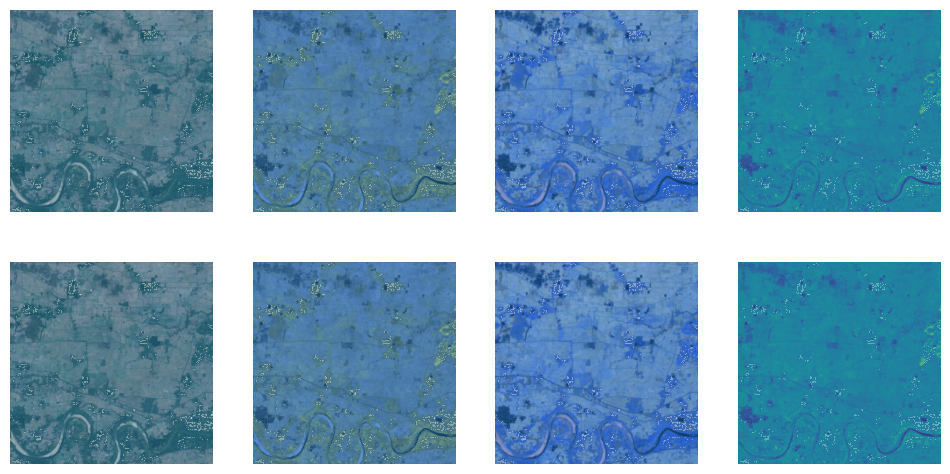

In [ ]:
_show_one(True)

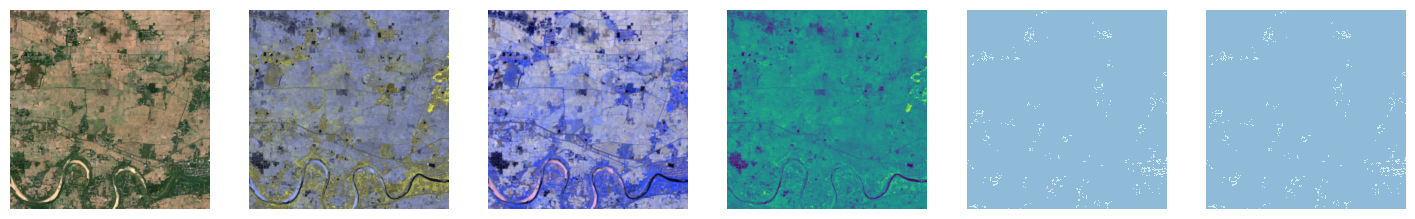

In [ ]:
_show_one(False)

# FastAI methods

Now we put these low level functions to use in developing the actual functions used by fastai.

In [ ]:
from fastgs.test.fixture import *

In [ ]:
learner = get_11b_test_learner()
learner.fit_one_cycle(1)

In [ ]:
#| export
@typedispatch
def show_results(x:TensorImageMS, y:TensorMask, samples, outs, ctxs=None, max_n=6,
                 nrows:int=None, ncols:int=None, figsize=None, mskovl:bool=True, **kwargs):
    assert nrows is None and ncols is None and ctxs is None
    rwcx = _get_sample_ctxs(x.num_images(), min(len(samples),max_n), mskovl, figsize)
    imgs,msks,otps = samples.itemgot(0),samples.itemgot(1),outs.itemgot(0)
    return [_show_one_result(img, msk, otp[0], row, mskovl, **kwargs) for img,msk,otp,row in zip(imgs, msks, outs, rwcx)]

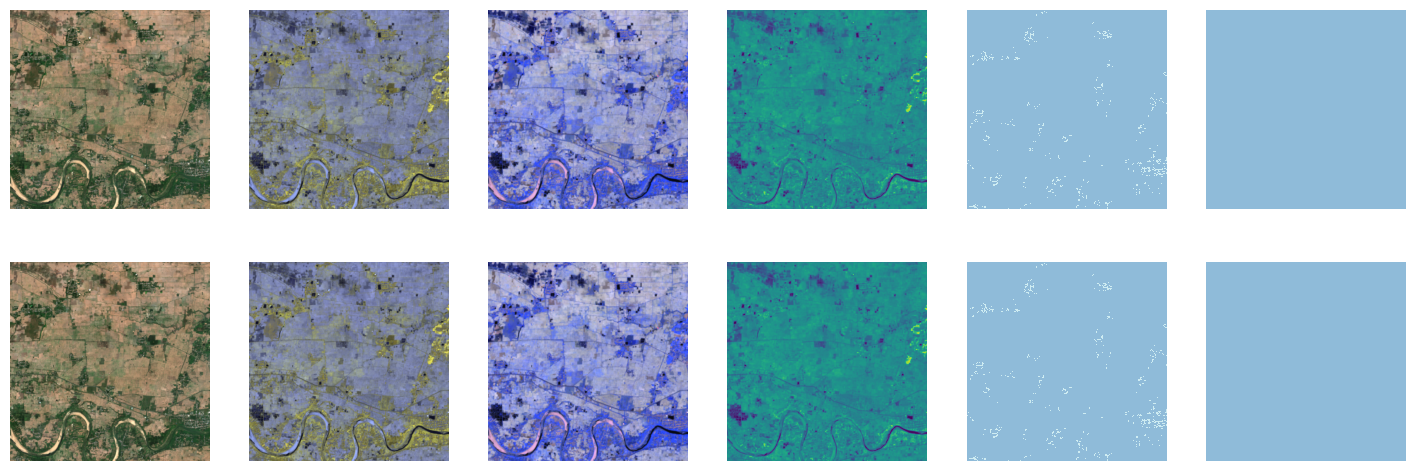

In [ ]:
learner.show_results(mskovl=False)

In [ ]:
#| export
@typedispatch
def plot_top_losses(x:TensorImageMS, y:TensorMask, samples, outs, raws, losses, nrows=None, ncols=None, figsize=None, mskovl: bool=True, **kwargs):
    assert nrows is None and ncols is None
    rwcx = _get_sample_ctxs(x.num_images(), len(samples), mskovl, figsize)
    [_show_one_result(s[0], s[1], o[0], row, mskovl, **kwargs) for row,s,o,l in zip(rwcx, samples, outs, losses)]

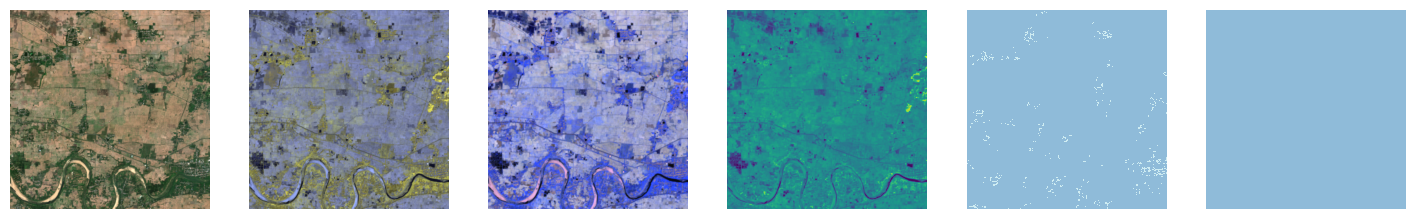

In [ ]:
interp = SegmentationInterpretation.from_learner(learner)
interp.plot_top_losses(k=1,mskovl=False)

# Pretrained model init

If `n_in` is > 3, the fastai vision models leave the weights for the first 3 channels the same (on the natural assumption that these correspond to true R, G, B channels). The weights of all channels greater than 3 is set to 0.

Assuming that the first 3 channels of our MS model are actual R, G, B channels, then a reasonable alternative is to initialize weights of all remaining channels to the average of the R,G,B weights.

If the first 3 channels do not correspond to actual R,G,B inputs, it may make sense to re-initialize **all** weights to the average R,G,B weights.

In [ ]:
#| export
@patch
def fastgs_reinit_weights(self:nn.Conv2d, reweight:str=None):
    w = self.weight.data
    if reweight in ["avg","avgall"]:
        avg = torch.mean(w[:,:3],1,True)
        if reweight == "avg":
            w[:,3:] = avg
        else:
            w = avg
        w = w * (3.0 / w.shape[1])

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()